In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import mpltern

import arviz as az
import pymc as pm
import pymc.distributions.transforms as transforms
from pymc_extras.utils.prior import prior_from_idata

from tqdm.notebook import tqdm

from collections import OrderedDict
from functools import partial

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src")

from data.GDGT_datasets import load_duncan2023, load_rattanasriampaipong2022, load_tierney2015, load_varma2024

%load_ext watermark

(10000, 2)
(10000, 2)


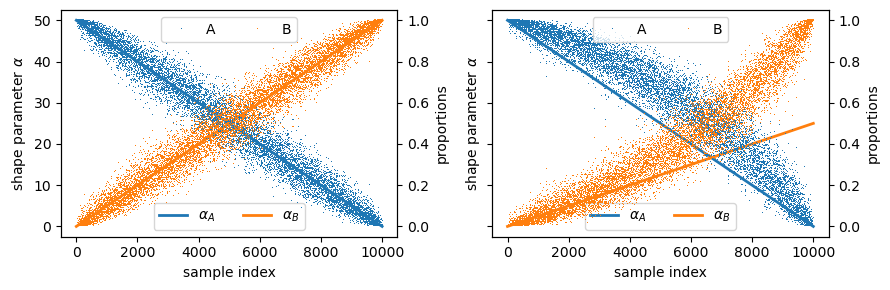

In [2]:
# 2d illustrative case to show difference between alphas and resulting proportions
rng = np.random.default_rng(1234)
N_OBS = 10_000

fig, ax = plt.subplots(1,2,figsize=(9,3), sharex=True, sharey=True)
for i,X in enumerate([50,25]):
    alpha =  np.stack([np.linspace(50,0,N_OBS),np.linspace(0,X,N_OBS)]).T
    # alpha =  np.stack([np.linspace(10,X,N_OBS),np.linspace(0,X*2,N_OBS)]).T
    print(alpha.shape)
    A, B = np.array([rng.dirichlet(alpha=alpha[i,:]) for i in range(N_OBS)]).T # this is our observed Y.

    alpha_mean = alpha/alpha.sum(axis=1)[:,None]

    ax[i].plot(alpha[:,0],'-',lw=2,label=r"$\alpha_A$")
    ax[i].plot(alpha[:,1],'-',lw=2,label=r"$\alpha_B$")
    # ax[i].plot(alpha[:,2],'-',lw=2,label=r"$\alpha_C$")
    ax[i].legend(loc=8,ncol=2)
    ax[i].set_ylabel(r"shape parameter $\alpha$")
    ax[i].set_xlabel("sample index")
    ax2 = ax[i].twinx()
    ax2.plot(A,',',label="A")
    ax2.plot(B,',',label="B")
    # ax2.plot(C,'.',ms=2,mew=0,label="C")
    ax2.legend(loc=9,ncol=2)
    ax2.set_ylabel("proportions")

    # ax2.plot(alpha_mean[:,0],'k--',lw=1)
    # ax2.plot(alpha_mean[:,1],'k--',lw=1)    

fig.tight_layout()

# Create synthetic data set

- Optional sampling from a distribution that is similar to an observed dataset (temperature values)
- Choose from either *Logistic Curve* or *MMRT* model

In [3]:
# Load observed data (we are interested in SST values)
df = load_tierney2015(as_frame=True).frame
display(df)
observed_x = df["SST"].values

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Longitude,Latitude,SST
0,0.5400,0.0420,0.0140,0.0020,0.3960,0.0070,-172.6500,-67.2167,0.2
1,0.5430,0.0310,0.0090,0.0020,0.4100,0.0050,174.2000,-65.1500,-0.2
2,0.3650,0.0580,0.0510,0.0030,0.4980,0.0240,140.0000,-60.0000,0.9
3,0.4320,0.0460,0.0250,0.0030,0.4840,0.0110,-170.0000,-50.0167,9.8
4,0.2510,0.0510,0.0630,0.0060,0.5860,0.0420,-160.0000,-47.0000,11.1
...,...,...,...,...,...,...,...,...,...
776,0.3426,0.0701,0.0614,0.0093,0.4837,0.0329,-18.5512,20.7463,20.2
777,0.3315,0.0699,0.0565,0.0101,0.4994,0.0325,-17.8607,19.9434,20.1
778,0.3279,0.0721,0.0593,0.0095,0.4982,0.0329,-17.2767,19.3567,20.1
779,0.3401,0.0727,0.0639,0.0097,0.4800,0.0336,-17.3348,18.6388,22.2


 True synthetic model parameters for 'mmrt': 
Topt = [268.15 273.15 283.15]
Trange = [20 30 25]
scale = [100  10  60]
Sampling: 'as_observed'
p = 1.0
(781, 3)


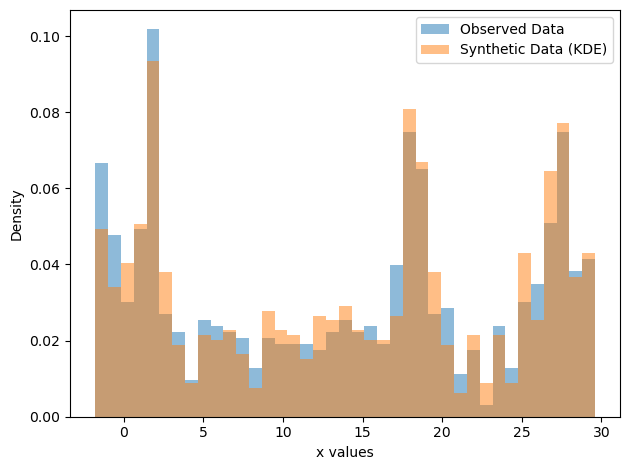

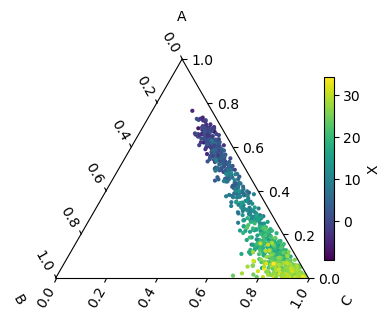

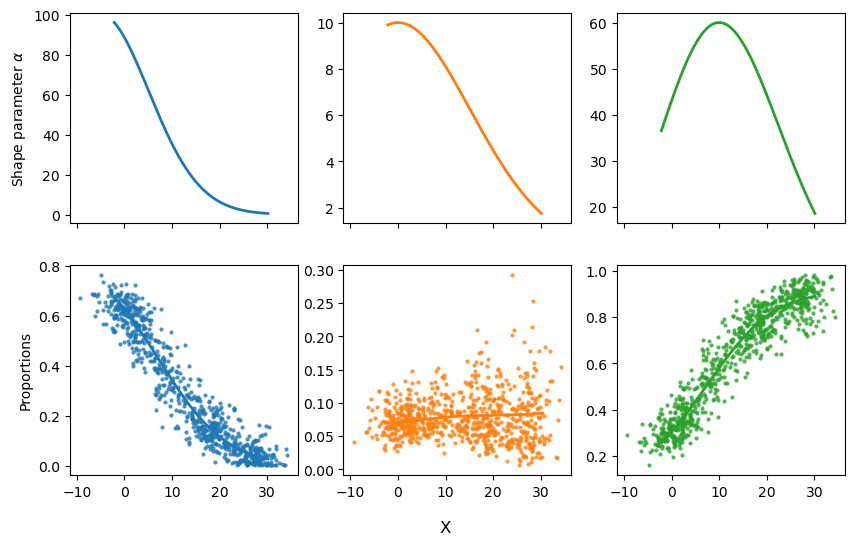

In [4]:
# Initialise random number generator
rng = np.random.default_rng(1234)

# some parameters
# for plotting histogram
BINS = len(df)//20
RANGE = (min(observed_x),max(observed_x))
# and for sampling the synthetic data (for the independent variable)
p = 1.0
N_OBS = int(len(df)*p)
SAMPLING = "as_linear"
SAMPLING = "as_observed"
X_SIGMA = 2.5

OUTLIER_FRACTION = 0

if SAMPLING == "as_observed":
    # Create a synthetic distribution using observed data
    # Use KDE to approximate the distribution
    kde = st.gaussian_kde(observed_x, bw_method=1/BINS)  # Fit KDE to the observed data
    synthetic_x_kde = kde.resample(size=1000, seed=rng).flatten()  # Generate synthetic data from KDE
    
    # Visualize the synthetic data
    fig, ax = plt.subplots(1,1)
    ax.hist(observed_x, bins=BINS, range=RANGE, density=True, alpha=0.5, label="Observed Data")
    ax.hist(synthetic_x_kde, bins=BINS, range=RANGE, density=True, alpha=0.5, label="Synthetic Data (KDE)")
    ax.set_xlabel("x values")
    ax.set_ylabel("Density")
    ax.legend()
    fig.tight_layout()

# define our model(s) that create shape parameters based on independent variable x (== temperature for our purposes)
def logistic_curve(x,L,k,x0,math_lib):
    return L/(1+math_lib.exp(-k*(x-x0)))

def mmrt(T, Topt, Trange, scale, math_lib=np):
    # T*exp((-T*T_range**2 + T*(2*T_opt - 1)**2*(-log(T) + log(T_opt) + 1) + T_opt*T_range**2 - T_opt*(2*T_opt - 1)**2)/(T*T_range**2))/T_opt
    T0 = 298.15 # 25°C
    T = T + 273.15
    return scale*(T*math_lib.exp((-T*Trange**2 + T*(2*Topt - 1)**2*(math_lib.log(Topt/T) + 1) + Topt*Trange**2 - Topt*(2*Topt - 1)**2)/(T*Trange**2))/Topt)

def no_model(T, a, math_lib=np):
    return a

if SAMPLING is "as_linear":
    # Evenly sampled (linear)
    Xmin = -2
    Xmax = 40
    X_true = np.linspace(Xmin,Xmax,N_OBS)
elif SAMPLING is "as_observed":
    # Unevenly sampled (from observed distribution)
    X_true = np.sort(kde.resample(size=N_OBS, seed=rng).flatten())
    Xmin = min(X_true)
    Xmax = max(X_true)

MODEL = "mmrt"

params_dict = OrderedDict()
if MODEL is "logistic":
    base_model        = logistic_curve
    params_dict["L"]  = np.array([ 20,  22, 90])
    params_dict["k"]  = np.array([0.08, 0.02, -0.15])
    params_dict["x0"] = np.array([15, 31, 0])
elif MODEL is "mmrt":
    base_model            = mmrt
    params_dict["Topt"]   = np.array([-5,0,10])+273.15
    # params_dict["Topt"]   = rng.uniform(260,330,size=3)
    params_dict["Trange"] = np.array([20,30,25])
    # params_dict["Trange"] = rng.lognormal(3.5,1,size=3)
    params_dict["scale"]  = np.array([10,1,6])*10
    # params_dict["scale"]  = rng.lognormal(3.5,1,size=3)*1
    
our_model = partial(base_model, math_lib=np)
our_model_pymc = partial(base_model, math_lib=pm.math)

s = f" True synthetic model parameters for '{MODEL}': "
print(s)
print("".join(["="]*len(s)))
for k,v in params_dict.items():
    print(f"{k} = {v}")
print("".join(["="]*len(s)))
print(f"Sampling: '{SAMPLING}'")
print(f"{p = }")
print("".join(["="]*len(s)))

params = [v for k,v in params_dict.items()]

X = rng.normal(X_true,X_SIGMA) # this is the predictor we observe

alpha = our_model(X_true[:, None],*params)
print(alpha.shape)
A, B, C = np.array([rng.dirichlet(alpha=alpha[i,:]) for i in range(N_OBS)]).T # this is our observed Y.
# A, B = np.array([rng.dirichlet(alpha=alpha[i,:2]) for i in range(N_OBS)]).T # this is our observed Y.

# Create outliers
outlier_deltas = []
if OUTLIER_FRACTION > 0:
    outlier_ids = rng.choice(np.arange(N_OBS), size=int(N_OBS*OUTLIER_FRACTION), replace=False)
    outlier_set = rng.choice(range(3), size=int(N_OBS*OUTLIER_FRACTION), replace=True)
    # print(outlier_set)
    for i,s in zip(outlier_ids, outlier_set):
        outlier_delta = rng.lognormal(0,1)
        if s == 0:
            A[i] *= outlier_delta
        elif s == 1:
            B[i] *= outlier_delta
        elif s == 2:
            C[i] *= outlier_delta
        outlier_deltas.append(outlier_delta)
        
        # Re-normalize A, B, C to sum to 1
        total = A[i] + B[i] + C[i]
        A[i] /= total
        B[i] /= total
        C[i] /= total

# fig, ax = plt.subplots(1,1)
# ax.hist(outlier_deltas)

# Ternary plot of three species
fig, ax = plt.subplots(1,1,figsize=(4,4), subplot_kw={"projection": "ternary"})
# fig, ax = plt.subplots(1,1,figsize=(4,4))
pc = ax.scatter(A, B, C, c=X, marker='.',lw=0)
# ax.plot(X, A, marker='.',lw=0)
# ax.plot(X, B, marker='.',lw=0)
plt.colorbar(pc,ax=ax,shrink=0.5,label='X')
ax.set_tlabel('A')
ax.set_llabel('B')
ax.set_rlabel('C')

fig.tight_layout()
# fig.savefig(f"../reports/figures/dirichlet_example_synthetic_data.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

X_cont = np.linspace(Xmin,Xmax,1000)
# panel plots of logistic curves
fig, ax = plt.subplots(2,3, figsize=(10,6), sharex=True)
alpha_mean = []
for i in range(3):
    ax[0,i].plot(X_cont,our_model(X_cont,*[p[i] for p in params]), lw=2, c=f'C{i}')
    alpha_mean.append(our_model(np.sort(X_cont),*[p[i] for p in params]))

alpha_mean = np.array(alpha_mean)
alpha_mean /= alpha_mean.sum(axis=0)


for i,y in enumerate([A,B,C]):
    ax[1,i].plot(X, y, '.', c=f'C{i}', mew=0, alpha=0.8)
    ax[1,i].plot(X_cont, alpha_mean[i,:], lw=2, c=f'C{i}')

ax[1,0].set_ylabel("Proportions")
ax[0,0].set_ylabel(r"Shape parameter $\alpha$")
_ = fig.supxlabel("X")

# Bayesian Inference Model

In [5]:
N_SAMPLES = 100

combined_indices = np.arange(N_OBS)
compound_names = ["A", "B", "C"]
# compound_names = ["A", "B"]

coords = {
    "obs": combined_indices,
    "compound": compound_names,
}

y = np.stack([A,B,C]).T
# y = np.stack([A,B]).T
print(y.shape)

INFERENCE_MODEL = MODEL
# INFERENCE_MODEL = "no_model"
# our_model_pymc = partial(no_model, math_lib=pm.math)

IS_MODEL = INFERENCE_MODEL != "no_model"

with pm.Model(coords=coords) as model:
    X_data = pm.Data("X_data", X, dims=("obs"))
    y_data = pm.Data("y_data", y, dims=("obs","compound"))

    
    # priors for model parameters
    pt_params = OrderedDict()
    if INFERENCE_MODEL is "logistic":
#         L_mean_prior = pm.LogNormal("L_mean", mu=1, sigma=2)
#         L_sigma      = pm.HalfNormal("L_sigma", sigma=1)
        L_mean_prior = 20
        L_sigma      = 5
        pt_params["L"]  = pm.TruncatedNormal("L", mu=L_mean_prior, sigma=L_sigma, lower=0, dims="compound")
        pt_params["k"]  = pm.Normal("k", mu=0, sigma=0.1, dims="compound")
        pt_params["x0"] = pm.Normal("x0", mu=0, sigma=5, dims="compound")
    elif INFERENCE_MODEL is "mmrt":
        # Topt_mean = 300
        # Trange_mean = 30
        # scale_mean = 3
        pt_params["Topt"] = pm.Normal("Topt", mu=params_dict["Topt"].mean(), sigma=params_dict["Topt"].std(), dims=("compound"))
        pt_params["Trange"] = pm.Normal("Trange", mu=params_dict["Trange"].mean(), sigma=params_dict["Trange"].std(), dims=("compound"))
        pt_params["scale"] = pm.TruncatedNormal("scale", mu=params_dict["scale"].mean(), sigma=params_dict["scale"].std(), lower=0, dims=("compound"))
    elif INFERENCE_MODEL == "no_model":
        print(f"{np.log(alpha).mean() = }")
        print(f"{np.log(alpha).std() = }")
        # a_mean = np.log(alpha).mean()#pm.Normal("a_mean", mu=2, sigma=2)
        # a_sigma = pm.HalfNormal("a_sigma", sigma=1)
        a_mean  = pm.Normal("a_mean", mu=np.log(alpha).mean(), sigma=np.log(alpha).std())
        pt_params["a"]    = pm.LogNormal("a", mu=a_mean, sigma=1, dims=("obs","compound"))
        # pt_params["a"]    = pm.Uniform("a", lower=0, upper=alpha.max(), dims=("obs","compound"))
        # print(pt_params["a"].eval().mean())
    for k,v in pt_params.items():
        print(f"{k}: {v.eval()}")
    # priors for independent variable
    X_true_ = pm.Normal("X_true", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))
    # X_sigma_ = pm.HalfNormal("X_sigma", sigma=1)
    X_sigma_ = X_SIGMA
    X_ = pm.Normal("X", mu=X_true_, sigma=X_sigma_, observed=X_data, dims=("obs"))

    # Likelihoods
    a_ = our_model_pymc(X_true_[:,None],*[v for _,v in pt_params.items()])
    y_ = pm.Dirichlet("y", a=a_, observed=y_data, dims=("obs","compound"))
    # print(f"{y_.eval().shape = }")    
    
    # Sample from prior
    trace = pm.sample_prior_predictive(samples=N_SAMPLES)

(781, 3)
Topt: [275.42009389 274.25708002 276.98607531]
Trange: [22.86050554 22.79639051 27.98617684]
scale: [ 58.74439063 109.46985133 122.44669685]


Sampling: [Topt, Trange, X, X_true, scale, y]


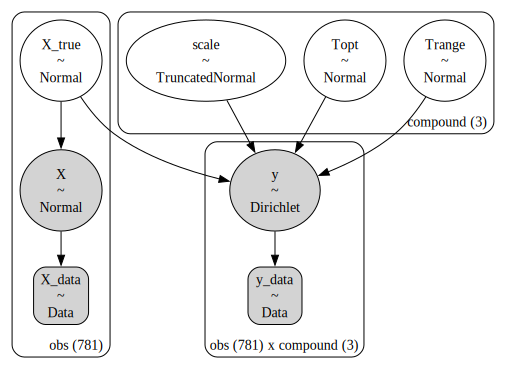

In [6]:
gv = pm.model_to_graphviz(model)
gv

In [7]:
model.free_RVs

[Topt ~ Normal(275, 6.24),
 Trange ~ Normal(25, 4.08),
 scale ~ TruncatedNormal(56.7, 36.8, 0, inf),
 X_true ~ Normal(13.4, 10.5)]

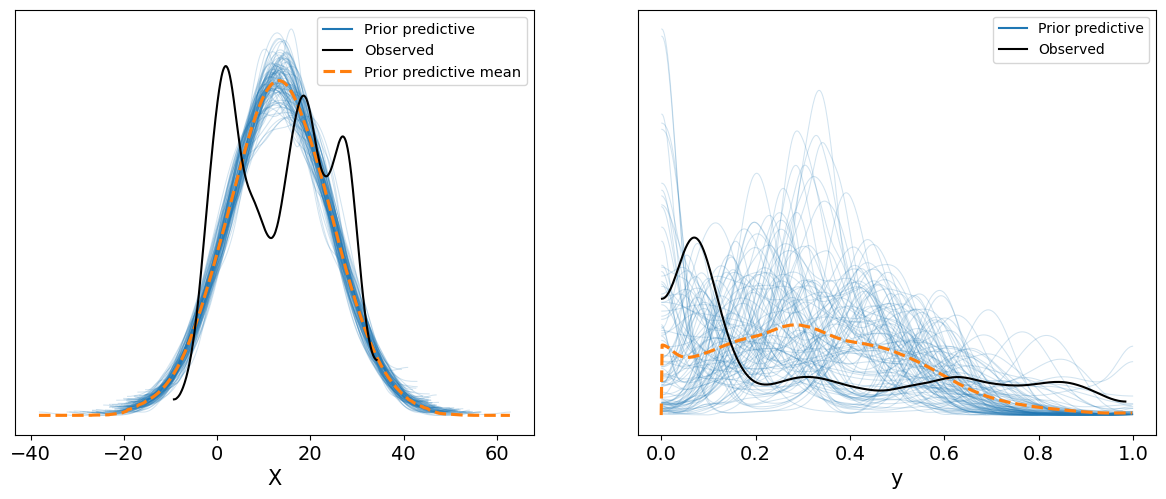

In [8]:
ax = az.plot_ppc(trace, group='prior', observed=True)

  0%|          | 0/100 [00:00<?, ?it/s]

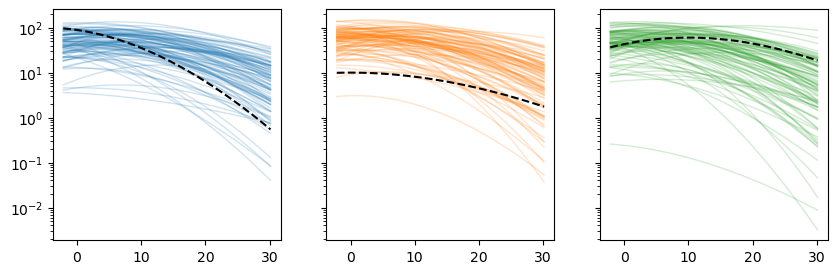

In [9]:
stacked = trace.stack(samples=("chain","draw"))
if IS_MODEL:
    fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)
    
    for n in tqdm(range(N_SAMPLES)):
        params_p = np.array([stacked.prior[k].isel(samples=n).values for k in pt_params.keys()])
        for i in range(3):
            ax[i].plot(X_true,our_model(X_true,*[p[i] for p in params_p]), lw=1, alpha=0.2, c=f'C{i}')
            
    for i in range(3):
        ax[i].plot(X_true,our_model(X_true,*[p[i] for p in params]), 'k--')
        ax[i].set_yscale("log")

In [10]:
# posterior (MCMC) sampling
with model:
    trace.extend(pm.sample())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Topt, Trange, scale, X_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.


In [11]:
var_names = ["~X_true"]

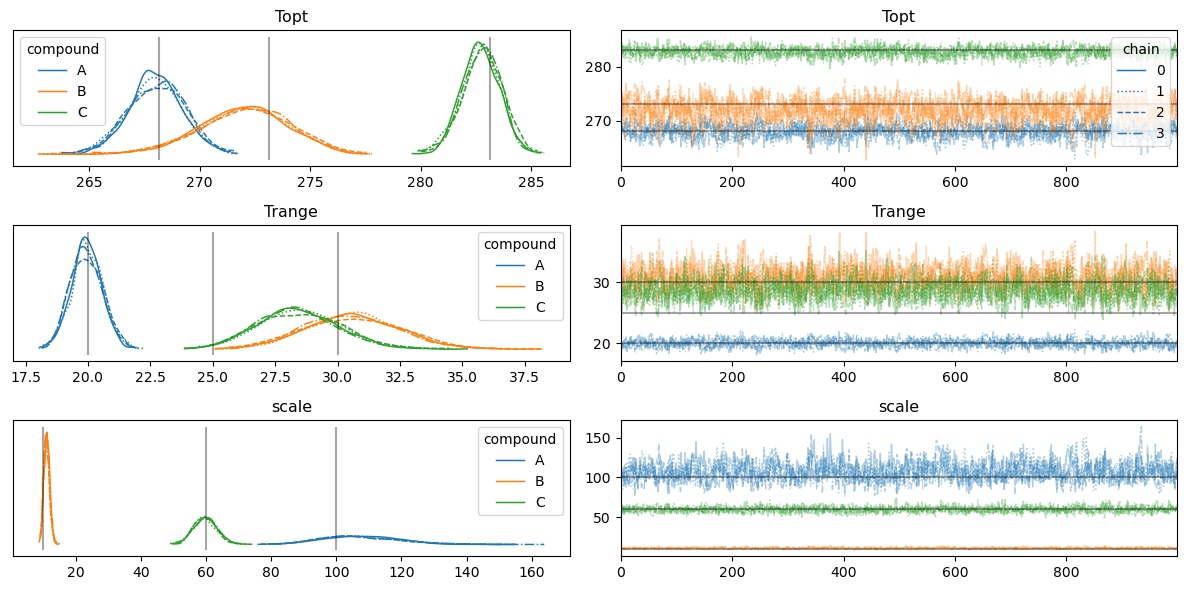

In [12]:
true_param_lines = [(k, {}, v) for k,v in params_dict.items()]
true_param_lines += [("X_sigma", {}, X_SIGMA)]

if IS_MODEL:
    ax = az.plot_trace(trace,var_names=var_names, lines=true_param_lines, legend=True)
    plt.tight_layout()
# else:
#     ax = az.plot_trace(trace,var_names=["~X_true", "~a"], legend=True)
#     plt.tight_layout()

In [13]:
with model:
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [X, y]


Output()

In [14]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

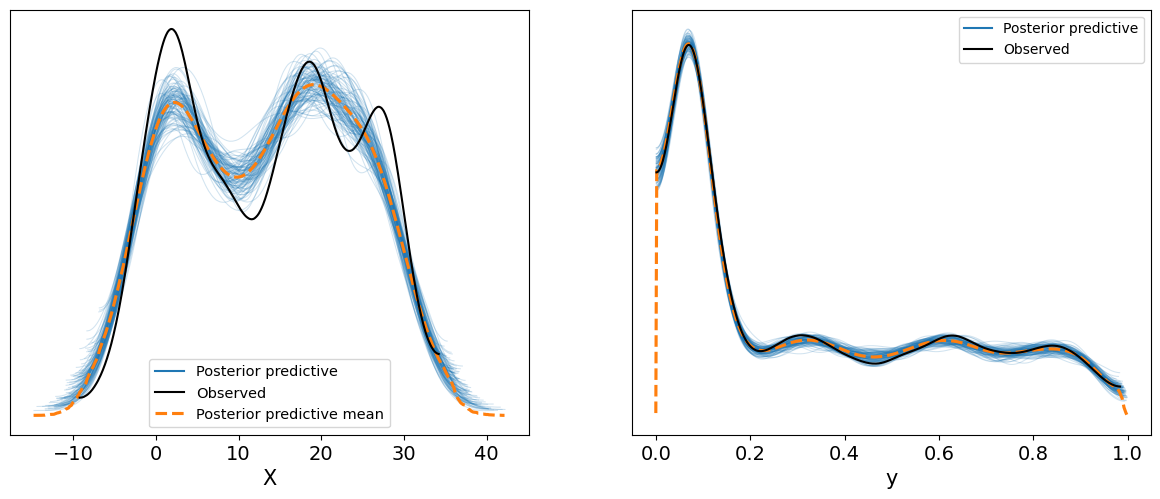

In [15]:
ax = az.plot_ppc(trace, num_pp_samples=100)

rmse = 2.30


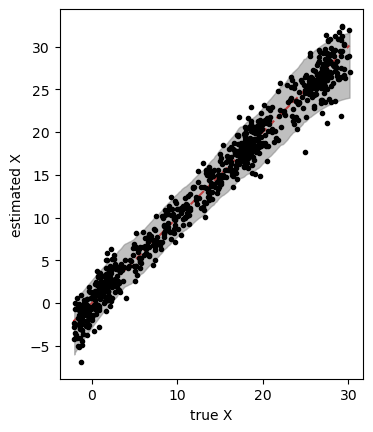

In [16]:
X_true_p = trace.posterior["X_true"].stack(samples=("chain","draw")).mean("samples")

fig, ax = plt.subplots(1,1)
ax.plot(X_true, X_true_p, 'k.')
ax.plot([min(X_true),max(X_true)], [min(X_true),max(X_true)], 'r--', zorder=-5)
az.plot_hdi(X_true, trace.posterior["X_true"],color='gray',ax=ax)
ax.set_aspect("equal")
ax.set_xlabel("true X")
ax.set_ylabel("estimated X")

rmse = (((trace.posterior["X_true"]-X_true)**2).mean())**0.5
print(f"{rmse = :.2f}")

(781, 3)
(781, 3)


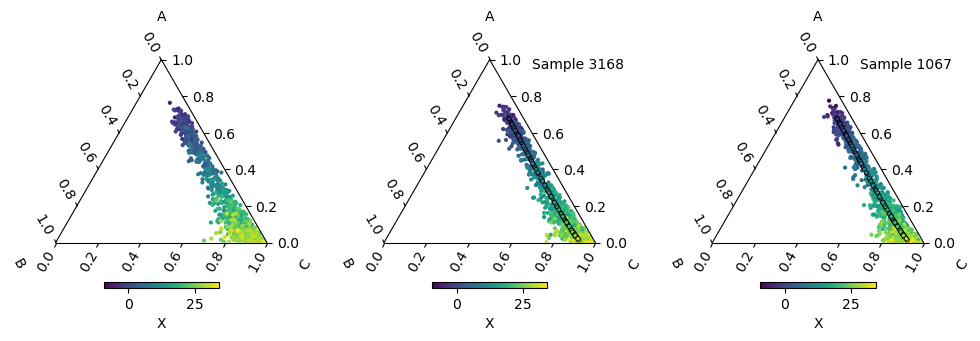

In [17]:
stacked = trace.stack(samples=("chain","draw"))
y_pred_mean = stacked.posterior_predictive["y"].mean("samples")
X_pred_mean = stacked.posterior_predictive["X"].mean("samples")

N_pp = 2
fig, ax = plt.subplots(1,1+N_pp,subplot_kw={"projection": "ternary"},figsize=(10,3.5))

vmin=min(X)
vmax=max(X)
pc = ax[0].scatter(A, B, C, c=X, vmin=vmin, vmax=vmax, marker='.', lw=0)

for i,s in enumerate(rng.choice(len(stacked.posterior_predictive.samples),2)):
    y_pred = stacked.posterior_predictive["y"].isel(samples=s)
    X_pred = stacked.posterior_predictive["X"].isel(samples=s)
    print(y_pred.shape)
    pc = ax[1+i].scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], c=X_pred, vmin=vmin, vmax=vmax, marker='.',lw=0)
    inc = 5
    ax[1+i].scatter(y_pred_mean[::inc,0], y_pred_mean[::inc,1], y_pred_mean[::inc,2], c=X_pred_mean[::inc], vmin=vmin, vmax=vmax, marker='.',lw=0.5, edgecolors='k')
    ax[1+i].text(0.7,0.95,f"Sample {s}",transform=ax[1+i].transAxes)

for a in ax:
    plt.colorbar(pc,ax=a,orientation="horizontal", shrink=0.5,label='X')
    a.set_tlabel('A')
    a.set_llabel('B')
    a.set_rlabel('C')

fig.tight_layout()

(4, 1000, 781, 3)


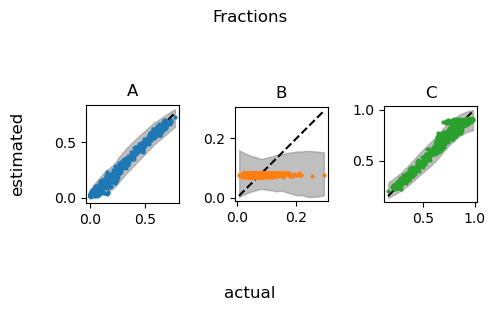

In [18]:
y_p = trace.posterior_predictive["y"].stack(samples=("chain","draw")).mean("samples").values
print(trace.posterior_predictive["y"].shape)

fig, ax = plt.subplots(1,3,figsize=(5,3))#,sharex=True,sharey=True)

for i in range(3):
    ax[i].plot([min(y[:,i]),max(y[:,i])],[min(y[:,i]),max(y[:,i])],'k--')
    ax[i].plot(y[:,i], y_p[:,i], ls='', marker='.', mew=0, color=f"C{i}")
    az.plot_hdi(y[:,i], trace.posterior_predictive["y"].sel(compound=compound_names[i]), color='gray', ax=ax[i])
    ax[i].set_aspect("equal")
    ax[i].set_title(compound_names[i])


fig.suptitle("Fractions")
fig.supxlabel("actual")
fig.supylabel("estimated")

fig.tight_layout()

In [19]:
if not IS_MODEL:
    alpha_p = trace.posterior["a"].stack(samples=("chain","draw")).mean("samples").values
    print(trace.posterior["a"].shape)
    
    fig, ax = plt.subplots(1,2,figsize=(5,3))#,sharex=True,sharey=True)
    
    for i in range(2):
        ax[i].plot([min(alpha[:,i]),max(alpha[:,i])],[min(alpha[:,i]),max(alpha[:,i])],'k--')
        ax[i].plot(alpha[:,i], alpha_p[:,i], ls='', marker='.', mew=0, color=f"C{i}")
        az.plot_hdi(alpha[:,i], trace.posterior["a"].sel(compound=compound_names[i]), color='gray', ax=ax[i])
        ax[i].set_title(compound_names[i])
    
    fig.suptitle("Shape parameters")
    fig.supxlabel("actual (mean)")
    fig.supylabel("estimated")
    
    fig.tight_layout()

  0%|          | 0/500 [00:00<?, ?it/s]

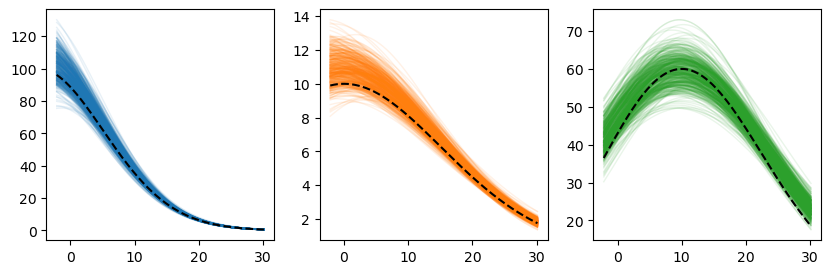

In [20]:
if IS_MODEL:
    fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True)
    
    N_TOTAL = len(stacked.posterior["samples"])
    
    for n in tqdm(rng.choice(range(N_TOTAL), size=500)):
        params_p = np.array([stacked.posterior[k].isel(samples=n).values for k in pt_params.keys()])
        for i in range(3):
            ax[i].plot(X_cont,our_model(X_cont,*[p[i] for p in params_p]), lw=1, alpha=0.1, c=f'C{i}')
            
    for i in range(3):
        ax[i].plot(X_cont,our_model(X_cont,*[p[i] for p in params]), 'k--')
    #     ax[i].set_yscale("log")

# Make predictions

In [21]:
N_OBS_TEST = 100
X_true_test = rng.uniform(low=Xmin,high=Xmax,size=N_OBS_TEST)

alpha_test = our_model(X_true_test[:, None],*params)
A_test, B_test, C_test = np.array([rng.dirichlet(alpha=alpha_test[i,:]) for i in range(N_OBS_TEST)]).T

combined_indices = np.arange(N_OBS_TEST)
compound_names = ["A", "B", "C"]

coords = {
    "obs": combined_indices,
    "compound": compound_names,
}

y_test = np.stack([A_test,B_test,C_test]).T
print(y_test.shape)

with pm.Model(coords=coords) as model_pred:
    y_data = pm.Data("y_data", y_test, dims=("obs","compound"))
    
    # priors for model parameters
    pt_params_pred = prior_from_idata(
        trace,
        var_names = pt_params.keys(),
        # **pt_params_transforms,
    )
    # priors for independent variable
    X_true_ = pm.Normal("X_true", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))
    # X_sigma_ = pm.HalfNormal("X_sigma", sigma=1)
    X_sigma_ = X_SIGMA
    X_ = pm.Normal("X", mu=X_true_, sigma=X_sigma_, dims=("obs"))

    # Likelihoods
    a_ = our_model_pymc(X_true_[:,None],*[v for _,v in pt_params_pred.items()])
    y_ = pm.Dirichlet("y", a=a_, observed=y_data, dims=("obs","compound"))
    print(f"{y_.eval().shape = }")

(100, 3)
y_.eval().shape = (100, 3)


In [22]:
with model_pred:
    trace_pred = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trace_prior_, X_true, X]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


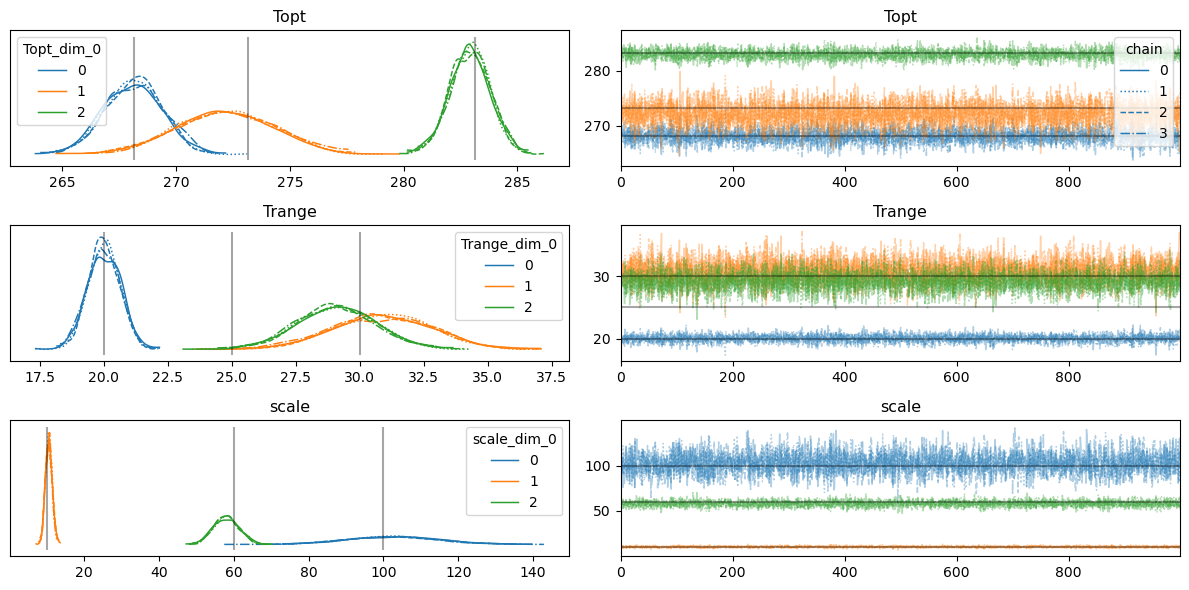

In [23]:
true_param_lines = [(k, {}, v) for k,v in params_dict.items()]
true_param_lines += [("X_sigma", {}, X_SIGMA)]

if IS_MODEL:
    ax = az.plot_trace(trace_pred,var_names=var_names+["~trace_prior_","~X"], lines=true_param_lines, legend=True)
    plt.tight_layout()
# else:
#     ax = az.plot_trace(trace,var_names=["~X_true", "~a"], legend=True)
#     plt.tight_layout()

In [24]:
with model_pred:
    trace_pred.extend(pm.sample_posterior_predictive(trace_pred))

Sampling: [y]


Output()

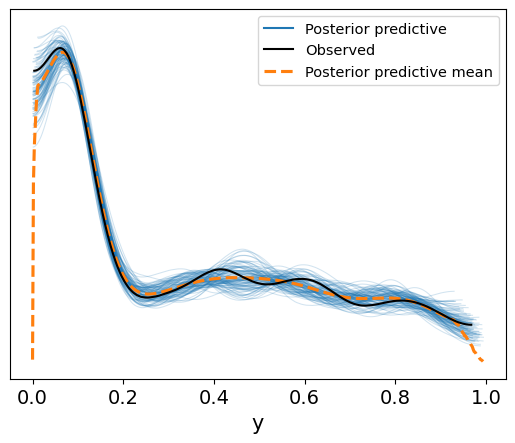

In [25]:
ax = az.plot_ppc(trace_pred, num_pp_samples=100)

rmse_pred = 3.25


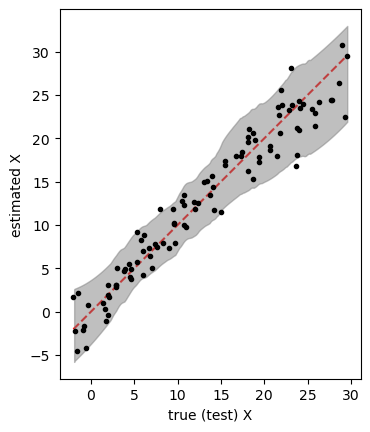

In [26]:
X_true_test_p = trace_pred.posterior["X_true"].stack(samples=("chain","draw")).mean("samples")

fig, ax = plt.subplots(1,1)
ax.plot(X_true_test, X_true_test_p, 'k.')
ax.plot([min(X_true_test),max(X_true_test)], [min(X_true_test),max(X_true_test)], 'r--', zorder=-5)
az.plot_hdi(X_true_test, trace_pred.posterior["X_true"],color='gray',ax=ax)
ax.set_aspect("equal")
ax.set_xlabel("true (test) X")
ax.set_ylabel("estimated X")

rmse_pred = (((trace_pred.posterior["X_true"]-X_true_test)**2).mean())**0.5
print(f"{rmse_pred = :.2f}")

In [27]:
%watermark
%watermark -iv

Last updated: 2025-03-24T15:05:43.969222+13:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

pandas     : 2.2.3
matplotlib : 3.10.1
tqdm       : 4.67.1
arviz      : 0.21.0
scipy      : 1.15.2
mpltern    : 0.0.0
sys        : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:25:12) [Clang 18.1.8 ]
pymc       : 5.21.1
pymc_extras: 0.2.4
numpy      : 2.2.4

